In [35]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import linear_model
from imblearn.ensemble import BalancedRandomForestClassifier
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.preprocessing import StandardScaler

In [36]:
data = pd.read_csv("processed_data.csv")

offense_columns = [
    'offense_name_CyberCrime', 'offense_name_DrugCrime', 'offense_name_Fraud',
    'offense_name_Gambling', 'offense_name_OtherCrime', 'offense_name_PropertyCrime',
    'offense_name_SexCrime', 'offense_name_ViolentCrime', 'offense_name_WeaponCrime'
]

data['offense_name_combined'] = data[offense_columns].idxmax(axis=1)

min_samples = 1000
class_counts = data['offense_name_combined'].value_counts()
low_count_classes = class_counts[class_counts < min_samples].index.tolist()

data['offense_name_combined'] = data['offense_name_combined'].apply(
    lambda x: x if x not in low_count_classes else 'offense_name_Other'
)

X = data.drop(offense_columns + ['offense_name_combined'], axis=1)
y = data['offense_name_combined']

data_combined = pd.concat([X, y], axis=1)
data_combined = data_combined.dropna()
X = data_combined.drop('offense_name_combined', axis=1)
y = data_combined['offense_name_combined']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [38]:
def predict_sgd_svm(x_train, y_train, x_test=None):
    sgd_svm = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
    sgd_svm.fit(x_train, y_train)
    if x_test is not None:
        y_prediction = sgd_svm.predict(x_test)
        return sgd_svm, y_prediction
    return sgd_svm

def predict_balanced_random_forest(x, Y):
    balanced_random_forest = BalancedRandomForestClassifier(
        n_estimators=100,
        random_state=42,
        sampling_strategy='all',
        replacement=True,
        bootstrap=False,
        n_jobs=-1
    )
    balanced_random_forest.fit(x, Y)
    return balanced_random_forest


def predict_logistic_regression(x, Y, z=None):
    logistic_regression = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
    logistic_regression.fit(x, Y)
    if z is not None:
        y_prediction = logistic_regression.predict(z)
        return logistic_regression, y_prediction
    return logistic_regression

def knn_algorithm(x, Y, z = 7):
    knn_prediction = KNeighborsClassifier(n_neighbors=z)
    knn_prediction.fit(x, Y)
    return knn_prediction

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()


In [39]:
print("Models before using SMOTE:")
models = ['Logistic Regression', 'SGD-based SVM', 'KNN', 'Balanced Random Forest']
accuracies_before_smote = []
accuracies_after_smote = []


Models before using SMOTE:


/Users/harrisonthayer/Library/Mobile Documents/com~apple~CloudDocs/Code/CPSC483/researchProjectDumpster/ProjectRepo/CPSC483Project/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Logistic Regression Model Performance:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.77      0.82      0.80       335
        offense_name_Fraud       0.00      0.00      0.00       230
        offense_name_Other       0.00      0.00      0.00       333
offense_name_PropertyCrime       0.86      0.67      0.75     13043
 offense_name_ViolentCrime       0.81      0.95      0.88     21185

                  accuracy                           0.83     35126
                 macro avg       0.49      0.49      0.49     35126
              weighted avg       0.82      0.83      0.82     35126

Accuracy: 0.8274782212606047


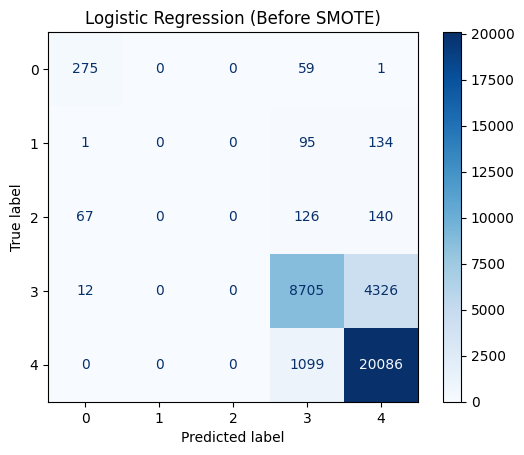

In [40]:
# Logistic Regression
logistic_model, logistic_predictions = predict_logistic_regression(X_train, y_train, X_test)
print("\nLogistic Regression Model Performance:")
print(classification_report(y_test, logistic_predictions, zero_division=0))
print("Accuracy:", accuracy_score(y_test, logistic_predictions))
pickle.dump(logistic_model, open("logistic_model_before_smote.pkl", "wb"))

plot_confusion_matrix(y_test, logistic_predictions, "Logistic Regression (Before SMOTE)")


SGD-based SVM Model Performance:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.85      0.56      0.68       335
        offense_name_Fraud       0.00      0.00      0.00       230
        offense_name_Other       0.33      0.11      0.16       333
offense_name_PropertyCrime       0.81      0.76      0.78     13043
 offense_name_ViolentCrime       0.85      0.91      0.88     21185

                  accuracy                           0.83     35126
                 macro avg       0.57      0.47      0.50     35126
              weighted avg       0.82      0.83      0.83     35126

Accuracy: 0.8330581335762683


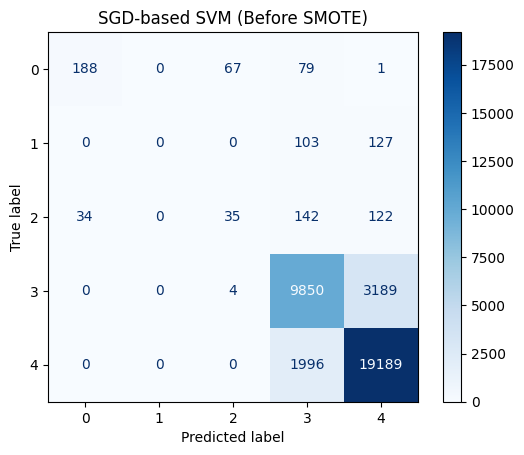

In [41]:
# SGD-based SVM
sgd_svm_model, sgd_svm_predictions = predict_sgd_svm(X_train, y_train, X_test)
print("\nSGD-based SVM Model Performance:")
print(classification_report(y_test, sgd_svm_predictions, zero_division=0))
print("Accuracy:", accuracy_score(y_test, sgd_svm_predictions))
pickle.dump(sgd_svm_model, open("sgd_svm_model_before_smote.pkl", "wb"))
plot_confusion_matrix(y_test, sgd_svm_predictions, "SGD-based SVM (Before SMOTE)")


KNN Model Performance:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.78      0.38      0.51       335
        offense_name_Fraud       0.25      0.01      0.02       230
        offense_name_Other       0.12      0.00      0.01       333
offense_name_PropertyCrime       0.82      0.65      0.72     13043
 offense_name_ViolentCrime       0.80      0.92      0.86     21185

                  accuracy                           0.80     35126
                 macro avg       0.55      0.39      0.42     35126
              weighted avg       0.79      0.80      0.79     35126

Accuracy: 0.8025109605420486


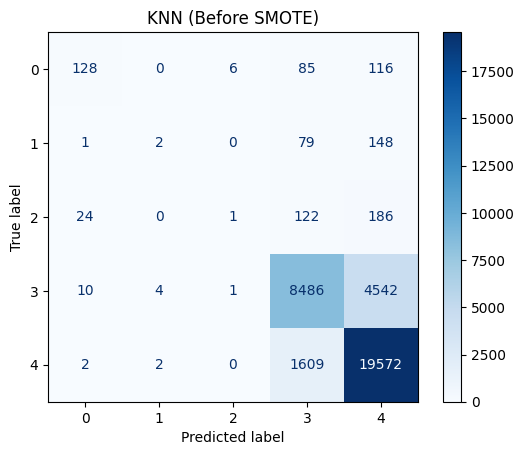

In [42]:
# KNN
knn_model = knn_algorithm(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
print("\nKNN Model Performance:")
print(classification_report(y_test, knn_predictions, zero_division=0))
print("Accuracy:", accuracy_score(y_test, knn_predictions))
pickle.dump(knn_model, open("knn_model_before_smote.pkl", "wb"))
plot_confusion_matrix(y_test, knn_predictions, "KNN (Before SMOTE)")


Balanced Random Forest Model Performance:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.65      0.94      0.77       335
        offense_name_Fraud       0.04      0.60      0.08       230
        offense_name_Other       0.06      0.22      0.09       333
offense_name_PropertyCrime       0.85      0.67      0.75     13043
 offense_name_ViolentCrime       0.88      0.83      0.85     21185

                  accuracy                           0.76     35126
                 macro avg       0.50      0.65      0.51     35126
              weighted avg       0.85      0.76      0.80     35126

Accuracy: 0.7623697545977338


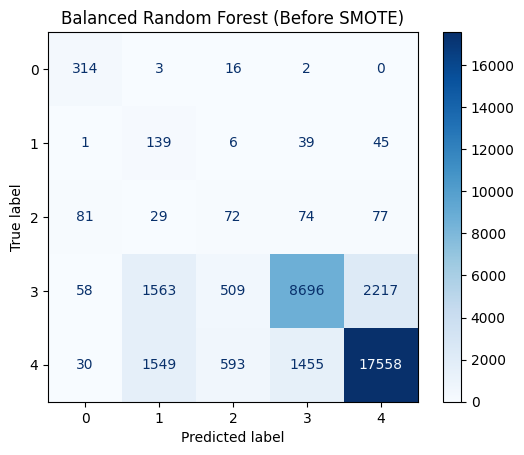

In [43]:
# Balanced Random Forest
rbf_model = predict_balanced_random_forest(X_train, y_train)
rbf_predictions = rbf_model.predict(X_test)
print("\nBalanced Random Forest Model Performance:")
print(classification_report(y_test, rbf_predictions, zero_division=0))
print("Accuracy:", accuracy_score(y_test, rbf_predictions))
pickle.dump(rbf_model, open("balanced_random_forest_before_smote.pkl", "wb"))
plot_confusion_matrix(y_test, rbf_predictions, "Balanced Random Forest (Before SMOTE)")

In [44]:
# Train and save models after using SMOTE
print("\n\n\nModels after using SMOTE:")




Models after using SMOTE:


/Users/harrisonthayer/Library/Mobile Documents/com~apple~CloudDocs/Code/CPSC483/researchProjectDumpster/ProjectRepo/CPSC483Project/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Logistic Regression Model Performance with SMOTE:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.59      0.98      0.74       335
        offense_name_Fraud       0.05      0.15      0.08       230
        offense_name_Other       0.07      0.02      0.03       333
offense_name_PropertyCrime       0.84      0.70      0.76     13043
 offense_name_ViolentCrime       0.84      0.91      0.87     21185

                  accuracy                           0.82     35126
                 macro avg       0.48      0.55      0.50     35126
              weighted avg       0.82      0.82      0.82     35126

Accuracy: 0.8164892102715937


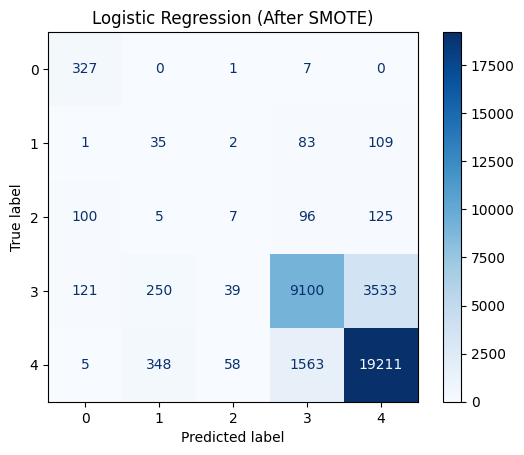

In [45]:
# Logistic Regression
logistic_model_smote, logistic_predictions_smote = predict_logistic_regression(X_train_resampled, y_train_resampled, X_test)
print("\nLogistic Regression Model Performance with SMOTE:")
print(classification_report(y_test, logistic_predictions_smote, zero_division=0))
print("Accuracy:", accuracy_score(y_test, logistic_predictions_smote))
pickle.dump(logistic_model_smote, open("logistic_model_after_smote.pkl", "wb"))
plot_confusion_matrix(y_test, logistic_predictions_smote, "Logistic Regression (After SMOTE)")


SGD-based SVM Model Performance with SMOTE:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.71      0.93      0.80       335
        offense_name_Fraud       0.03      0.37      0.06       230
        offense_name_Other       0.06      0.02      0.03       333
offense_name_PropertyCrime       0.78      0.74      0.76     13043
 offense_name_ViolentCrime       0.87      0.80      0.83     21185

                  accuracy                           0.77     35126
                 macro avg       0.49      0.57      0.50     35126
              weighted avg       0.82      0.77      0.79     35126

Accuracy: 0.7680350737345556


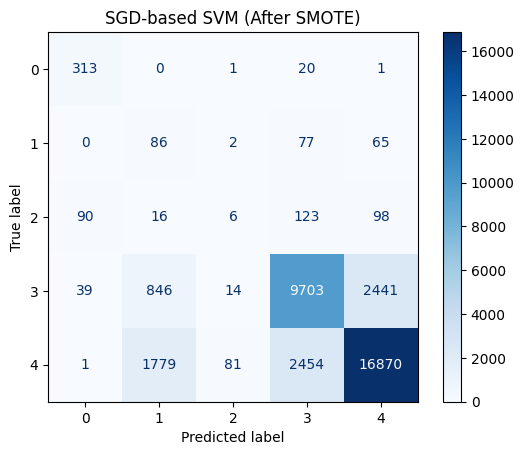

In [46]:
# SGD-based SVM
sgd_svm_model_smote = predict_sgd_svm(X_train_resampled, y_train_resampled)
sgd_svm_predictions_smote = sgd_svm_model_smote.predict(X_test)
print("\nSGD-based SVM Model Performance with SMOTE:")
print(classification_report(y_test, sgd_svm_predictions_smote, zero_division=0))
print("Accuracy:", accuracy_score(y_test, sgd_svm_predictions_smote))
pickle.dump(sgd_svm_model_smote, open("sgd_svm_model_after_smote.pkl", "wb"))
plot_confusion_matrix(y_test, sgd_svm_predictions_smote, "SGD-based SVM (After SMOTE)")


KNN Model Performance with SMOTE:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.35      0.71      0.47       335
        offense_name_Fraud       0.02      0.20      0.04       230
        offense_name_Other       0.02      0.17      0.04       333
offense_name_PropertyCrime       0.73      0.63      0.68     13043
 offense_name_ViolentCrime       0.85      0.74      0.79     21185

                  accuracy                           0.69     35126
                 macro avg       0.40      0.49      0.40     35126
              weighted avg       0.79      0.69      0.74     35126

Accuracy: 0.6932186984000456


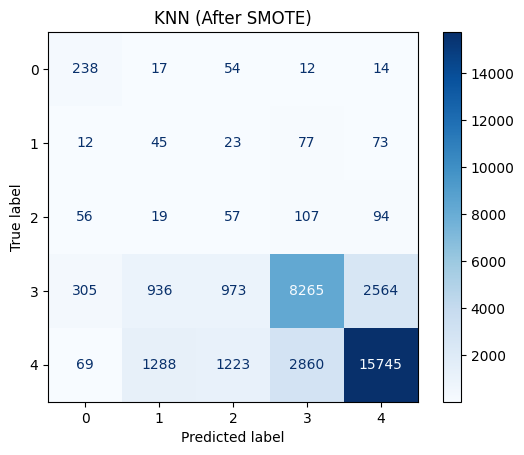

In [47]:
# KNN
knn_model_smote = knn_algorithm(X_train_resampled, y_train_resampled)
knn_predictions_smote = knn_model_smote.predict(X_test)
print("\nKNN Model Performance with SMOTE:")
print(classification_report(y_test, knn_predictions_smote, zero_division=0))
print("Accuracy:", accuracy_score(y_test, knn_predictions_smote))
pickle.dump(knn_model_smote, open("knn_model_after_smote.pkl", "wb"))
plot_confusion_matrix(y_test, knn_predictions_smote, "KNN (After SMOTE)")


Balanced Random Forest Model Performance with SMOTE:
                            precision    recall  f1-score   support

    offense_name_DrugCrime       0.79      0.92      0.85       335
        offense_name_Fraud       0.29      0.02      0.04       230
        offense_name_Other       0.38      0.10      0.15       333
offense_name_PropertyCrime       0.84      0.77      0.81     13043
 offense_name_ViolentCrime       0.86      0.92      0.89     21185

                  accuracy                           0.85     35126
                 macro avg       0.63      0.55      0.55     35126
              weighted avg       0.85      0.85      0.85     35126

Accuracy: 0.8535273017138302


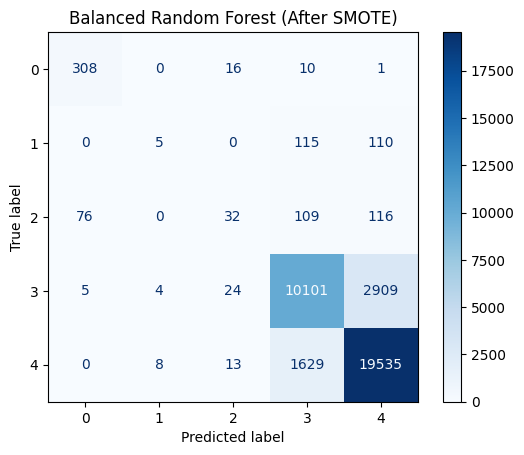

In [48]:
# Balanced Random Forest
rbf_model_smote = predict_balanced_random_forest(X_train_resampled, y_train_resampled)
rbf_predictions_smote = rbf_model_smote.predict(X_test)
print("\nBalanced Random Forest Model Performance with SMOTE:")
print(classification_report(y_test, rbf_predictions_smote, zero_division=0))
print("Accuracy:", accuracy_score(y_test, rbf_predictions_smote))
pickle.dump(rbf_model_smote, open("balanced_random_forest_after_smote.pkl", "wb"))
plot_confusion_matrix(y_test, rbf_predictions_smote, "Balanced Random Forest (After SMOTE)")

In [49]:
accuracies_before_smote.append(accuracy_score(y_test, logistic_predictions))
accuracies_before_smote.append(accuracy_score(y_test, sgd_svm_predictions))
accuracies_before_smote.append(accuracy_score(y_test, knn_predictions))
accuracies_before_smote.append(accuracy_score(y_test, rbf_predictions))

accuracies_after_smote.append(accuracy_score(y_test, logistic_predictions_smote))
accuracies_after_smote.append(accuracy_score(y_test, sgd_svm_predictions_smote))
accuracies_after_smote.append(accuracy_score(y_test, knn_predictions_smote))
accuracies_after_smote.append(accuracy_score(y_test, rbf_predictions_smote))



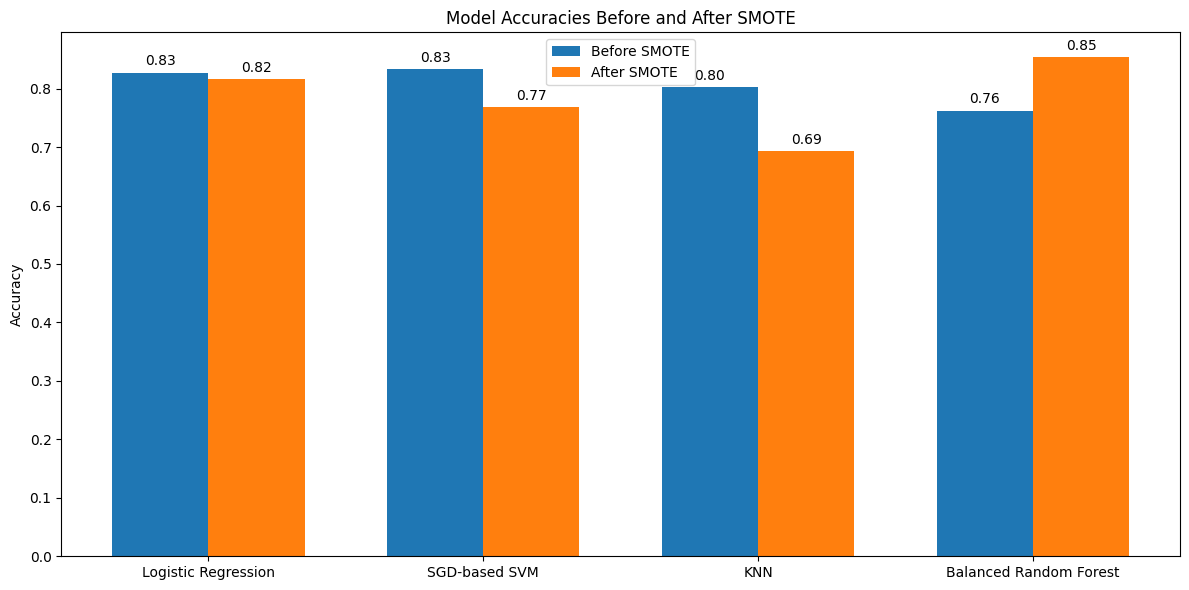

In [50]:
x = np.arange(len(models))
width = 0.35 

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, accuracies_before_smote, width, label='Before SMOTE')
rects2 = ax.bar(x + width/2, accuracies_after_smote, width, label='After SMOTE')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies Before and After SMOTE')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in rects, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


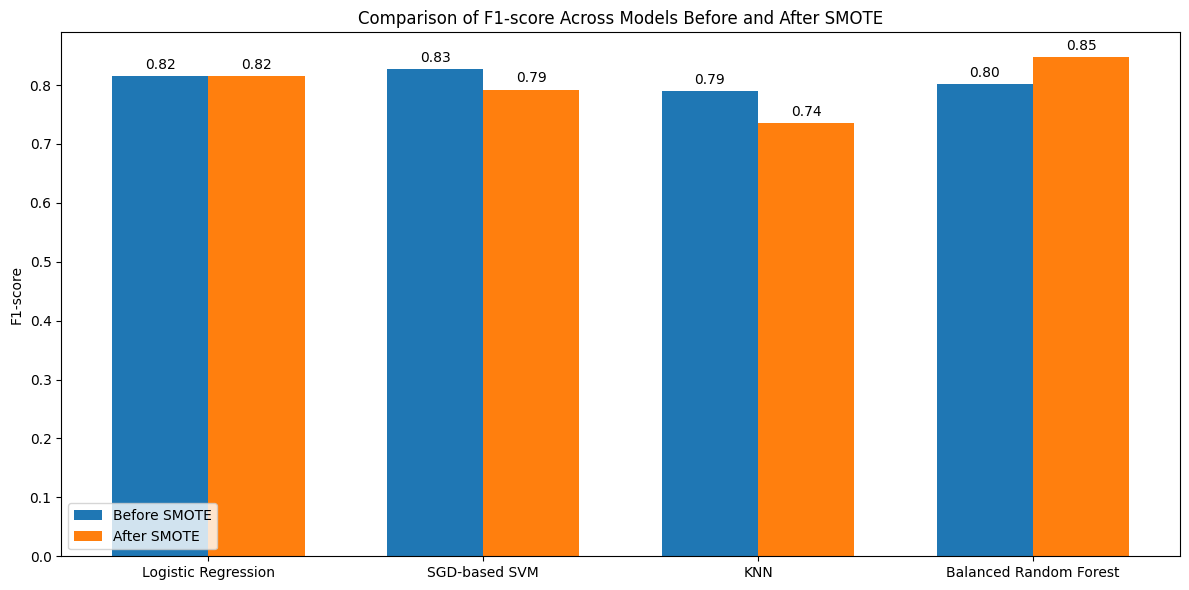

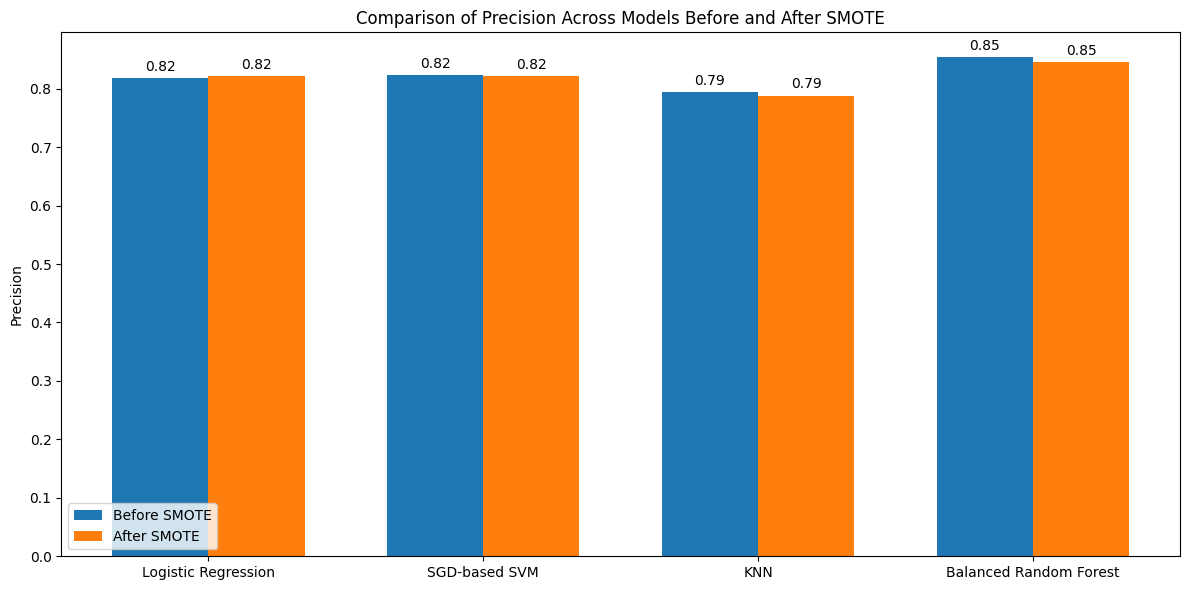

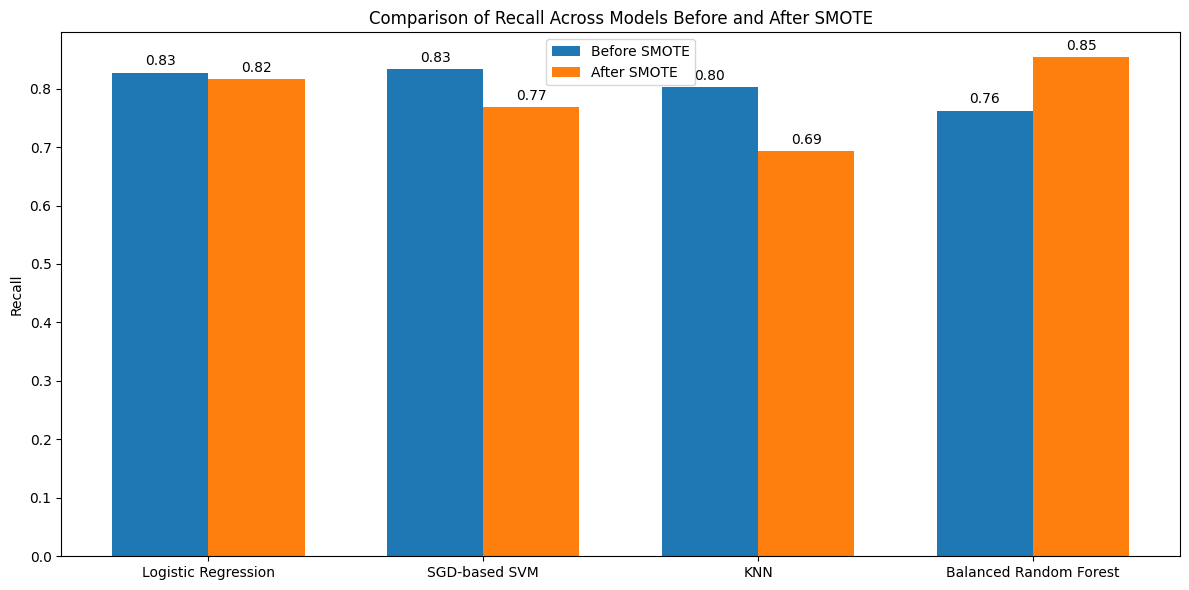

In [51]:
models_metrics_before_smote = {}
for model_name, y_pred in [('Logistic Regression', logistic_predictions),
                           ('SGD-based SVM', sgd_svm_predictions),
                           ('KNN', knn_predictions),
                           ('Balanced Random Forest', rbf_predictions)]:
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    models_metrics_before_smote[model_name] = {
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }

models_metrics_after_smote = {}
for model_name, y_pred in [('Logistic Regression', logistic_predictions_smote),
                           ('SGD-based SVM', sgd_svm_predictions_smote),
                           ('KNN', knn_predictions_smote),
                           ('Balanced Random Forest', rbf_predictions_smote)]:
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    models_metrics_after_smote[model_name] = {
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }

def compare_models_metrics(models_metrics_before, models_metrics_after, metric_name):
    labels = list(models_metrics_before.keys())
    metrics_before = [metrics_dict[metric_name] for metrics_dict in models_metrics_before.values()]
    metrics_after = [metrics_dict[metric_name] for metrics_dict in models_metrics_after.values()]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, metrics_before, width, label='Before SMOTE')
    rects2 = ax.bar(x + width/2, metrics_after, width, label='After SMOTE')

    ax.set_ylabel(metric_name.capitalize())
    ax.set_title(f'Comparison of {metric_name.capitalize()} Across Models Before and After SMOTE')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

compare_models_metrics(models_metrics_before_smote, models_metrics_after_smote, 'f1-score')
compare_models_metrics(models_metrics_before_smote, models_metrics_after_smote, 'precision')
compare_models_metrics(models_metrics_before_smote, models_metrics_after_smote, 'recall')